In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2023-03-08 01:08:22.665460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 01:08:22.751742: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-08 01:08:23.211579: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nimahsn-wsl/anaconda3/lib/:/home/nimahsn-wsl/anaconda3/lib/:/home/nimahsn-wsl/anaconda3/lib

In [2]:
from data.reaction_diffusion import reaction_diffusion_discrete_solution
from modules.models import ReactionDiffusionPinn, create_dense_model
from modules.data import simulate_reaction_diffusion
from modules.plots import plot_training_loss_linlog
from modules.utils import PrintLossCallback
from modules.initializers import NtkNormal

In [3]:
tf.keras.backend.set_floatx('float32')

In [4]:
nt = 150
nx = 256
n_samples = 150
n_init = 256
n_bcs = 300
u0 = 'gauss'
rho = 15.0
nu = 13.0
(tx_samples, u_samples, y_residuals), (tx_init, u_init), (tx_bnd, u_bnd), (X, T, U) = simulate_reaction_diffusion(
    n_samples, n_init, n_bcs, reaction_diffusion_discrete_solution, u0, nu, rho, time_steps=nt, x_steps=nx, interior_only=True, add_bnd=True)

2023-03-08 01:08:24.534317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-08 01:08:24.547168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-08 01:08:24.547202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-08 01:08:24.547785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other ope

In [5]:
inputs = [tx_samples, tx_init, tx_bnd]
outputs = [u_samples, y_residuals, u_init, u_bnd]

# Standard API

In [32]:
# create tensorflow datasets of txs and us
ds_tx_samples = tf.data.Dataset.from_tensor_slices(tx_samples)
ds_u_samples = tf.data.Dataset.from_tensor_slices(u_samples)
ds_y_residuals = tf.data.Dataset.from_tensor_slices(y_residuals)
ds_tx_init = tf.data.Dataset.from_tensor_slices(tx_init).repeat(2)
ds_u_init = tf.data.Dataset.from_tensor_slices(u_init).repeat(2)
ds_tx_bnd = tf.data.Dataset.from_tensor_slices(tx_bnd).repeat(2)
ds_u_bnd = tf.data.Dataset.from_tensor_slices(u_bnd).repeat(2)

ds_inputs = tf.data.Dataset.zip((ds_tx_samples, ds_tx_init, ds_tx_bnd))
ds_outputs = tf.data.Dataset.zip((ds_u_samples, ds_y_residuals, ds_u_init, ds_u_bnd))
dataset = tf.data.Dataset.zip((ds_inputs, ds_outputs)).batch(128)

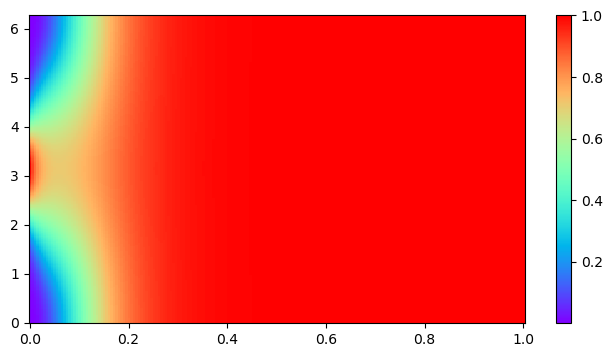

In [16]:
# plot color map of solution
plt.figure(figsize=(8, 4))
plt.pcolormesh(T, X, U, cmap='rainbow')
plt.colorbar()

In [17]:
backbone = create_dense_model([500, 500], activation='tanh', initializer='glorot_normal', \
    n_inputs=2, n_outputs=1)
reaction_f = ReactionDiffusionPinn.get_fishers_reaction_function(rho)
model = ReactionDiffusionPinn(backbone, nu, reaction_f) 
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(5e-4, decay_steps=500, decay_rate=0.98)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
model.compile(optimizer=optimizer)

In [18]:
cb = [PrintLossCallback(2000-1)]
history = model.fit(dataset, epochs=20000, batch_size=100, verbose=0, callbacks=cb)


Epoch: 000000, Lr: 536.16003, Li: 0.74929, Lb: 1.78941, MAE: 1.16271
Epoch: 001999, Lr: 0.14859, Li: 0.07088, Lb: 0.01139, MAE: 0.04359
Epoch: 003998, Lr: 0.03247, Li: 0.06515, Lb: 0.01087, MAE: 0.03397
Epoch: 005997, Lr: 0.00411, Li: 0.05908, Lb: 0.00864, MAE: 0.02598
Epoch: 007996, Lr: 0.00619, Li: 0.05574, Lb: 0.00743, MAE: 0.02479
Epoch: 009995, Lr: 0.00594, Li: 0.04768, Lb: 0.00570, MAE: 0.02159
Epoch: 011994, Lr: 0.00629, Li: 0.04129, Lb: 0.00408, MAE: 0.01838
Epoch: 013993, Lr: 0.00571, Li: 0.03614, Lb: 0.00322, MAE: 0.01636
Epoch: 015992, Lr: 0.00545, Li: 0.03144, Lb: 0.00266, MAE: 0.01538
Epoch: 017991, Lr: 0.00574, Li: 0.02715, Lb: 0.00213, MAE: 0.01445
Epoch: 019990, Lr: 0.00548, Li: 0.02343, Lb: 0.00176, MAE: 0.01354


1600/1600 [==============================] - 2s 1ms/step


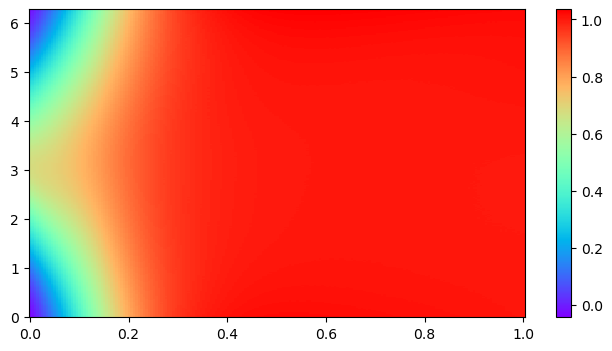

In [ ]:
# plot prediction
u_pred = backbone.predict(tf.concat([tf.reshape(T, (-1, 1)), tf.reshape(X, (-1, 1))], axis=1))
plt.figure(figsize=(8, 4))
plt.pcolormesh(T, X, tf.reshape(u_pred, T.shape), cmap='rainbow')
plt.colorbar()

In [20]:
# save backbone
backbone.save('backbone.h5')

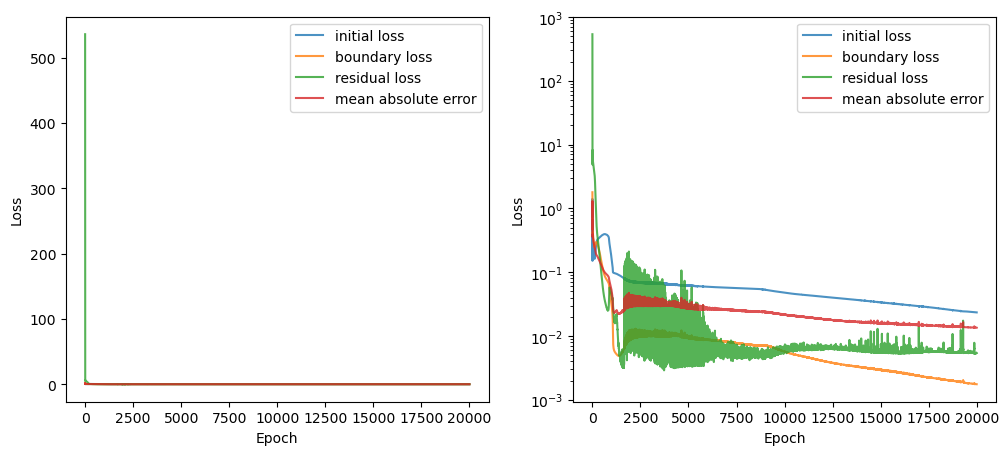

In [21]:
plot_training_loss_linlog(history.history)

In [22]:
from modules.plots import plot_pointwise_error_mesh

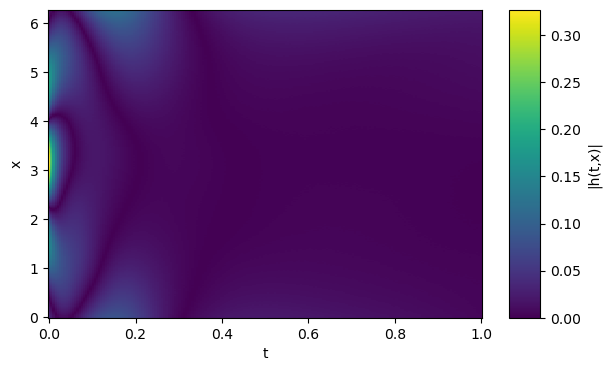

In [23]:
plot_pointwise_error_mesh(tf.reshape(U, (-1, 1)), tf.reshape(u_pred, [-1, 1]), T, X)

# Custom Fit

In [6]:
ub = np.max(tx_samples, axis=0)
lb = np.min(tx_samples, axis=0)
backbone = create_dense_model([1000, 1000], activation='tanh', initializer='glorot_normal', \
    n_inputs=2, n_outputs=1)
reaction_f = ReactionDiffusionPinn.get_fishers_reaction_function(rho)
model = ReactionDiffusionPinn(backbone, nu, lb, ub, reaction_f) 
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=500, decay_rate=0.975)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
model.compile(optimizer=optimizer)

In [7]:
history = model.fit_custom(inputs, outputs, 55000, 2000-1)

2023-03-08 01:08:36.733864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-08 01:08:36.772681: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fbe49732670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-08 01:08:36.772725: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-03-08 01:08:36.776358: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-08 01:08:36.876571: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 0, Loss Residual: 353.5374, Loss Initial: 0.9224, Loss Boundary: 2.2647, MAE: 1.2055
Epoch 1999, Loss Residual: 3.1555, Loss Initial: 0.2455, Loss Boundary: 0.4560, MAE: 0.4319
Epoch 3998, Loss Residual: 1.1080, Loss Initial: 0.2868, Loss Boundary: 0.4457, MAE: 0.4180
Epoch 5997, Loss Residual: 0.2377, Loss Initial: 0.3112, Loss Boundary: 0.3201, MAE: 0.3834
Epoch 7996, Loss Residual: 0.0408, Loss Initial: 0.3280, Loss Boundary: 0.1447, MAE: 0.3092
Epoch 9995, Loss Residual: 0.0240, Loss Initial: 0.2094, Loss Boundary: 0.0410, MAE: 0.1986
Epoch 11994, Loss Residual: 0.0044, Loss Initial: 0.1086, Loss Boundary: 0.0063, MAE: 0.1234
Epoch 13993, Loss Residual: 0.0271, Loss Initial: 0.0876, Loss Boundary: 0.0046, MAE: 0.1201
Epoch 15992, Loss Residual: 0.0074, Loss Initial: 0.0773, Loss Boundary: 0.0042, MAE: 0.1154
Epoch 17991, Loss Residual: 0.0058, Loss Initial: 0.0683, Loss Boundary: 0.0045, MAE: 0.1103
Epoch 19990, Loss Residual: 0.0062, Loss Initial: 0.0602, Loss Boundary: 0.00

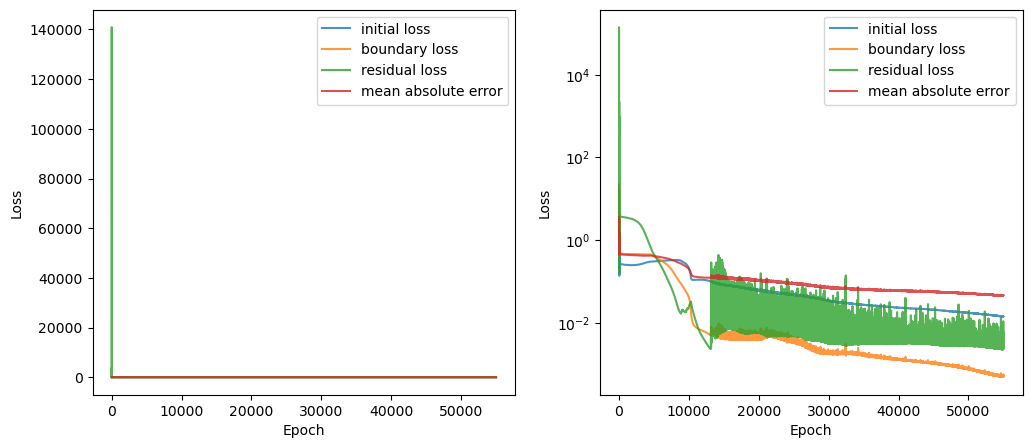

In [8]:
plot_training_loss_linlog(history)

1200/1200 [==============================] - 1s 1ms/step


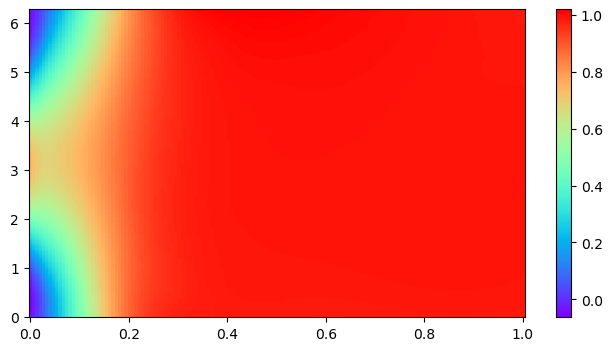

In [9]:
u_pred = backbone.predict(tf.concat([tf.reshape(T, (-1, 1)), tf.reshape(X, (-1, 1))], axis=1))
plt.figure(figsize=(8, 4))
plt.pcolormesh(T, X, tf.reshape(u_pred, T.shape), cmap='rainbow')
plt.colorbar()